# Final Project

Waveguides


Forrest Short

In [1]:
import meep as mp
import math
import scipy
import scipy.constants
import scipy.special
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Video
import os

%matplotlib inline

disable_video = 0;
clear_video = 0;
enable_output = 1;

/home/mint/anaconda3/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mint/anaconda3/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mint/anaconda3/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mint/anaconda3/envs/meep/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# I like having disk space
if clear_video > 0:
    os.remove(filename1)
    os.remove(filename2)
    os.remove(filename3)
    os.remove(filename4)
    os.remove(filename5)
    os.remove(filename6)

## Waveguides

     block, center = (0,0,0)
          size (16,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


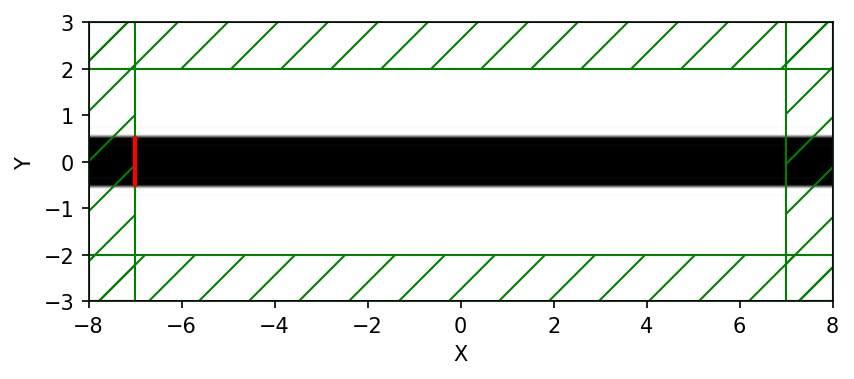

     block, center = (0,0,0)
          size (16,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


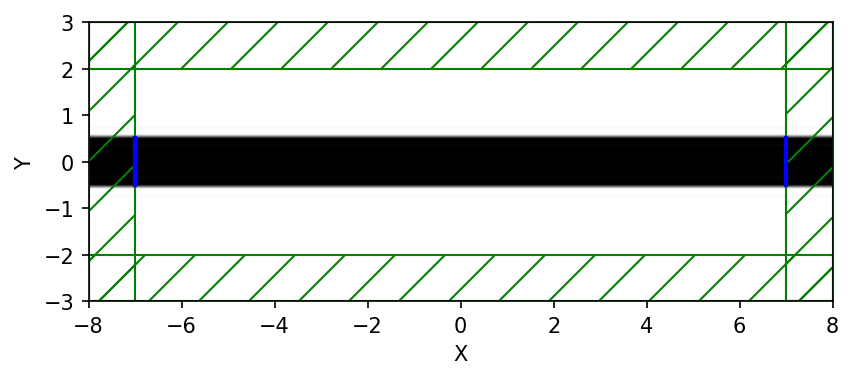

-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 2D dimensions.
Computational cell is 16 x 6 x 0 with resolution 10
     block, center = (0,0,0)
          size (16,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.01266 s
-----------
field decay(t = 50.050000000000004): 1.103427767964368e-08 / 1.103427767964368e-08 = 1.0
field decay(t = 100.05000000000001): 0.028858900979614216 / 0.028858900979614216 = 1.0
field decay(t = 150.1): 0.026289202480513627 / 0.028858900979614216 = 0.9109564670908358
field decay(t = 200.15): 2.126401654440992e-14 / 0.028858900979614216 = 7.368269692401216e-13
run 0 finished at t = 200.15 (4003 timesteps)


In [9]:
cell = mp.Vector3(16, 6, 0) # This sets a 2D area for the simulation. Z is zero, this is flat 2D

# The following geometry is defining the waveguide. 
geometry = [
    mp.Block(
        mp.Vector3(16, 1, mp.inf), # Waveguide is 16 long, 1 wide, infinite Z (2D)
        center=mp.Vector3(0, 0), # Centered on (X=0,Y=0)
        material=mp.Medium(epsilon=12), # Material type
    ),

]
pml_layers = [mp.PML(1.0)] # Perfectly Macthed Layer, This absorbs radiated waves at the edges of the sim.
resolution = 10

# This defines the radiation source. 
sources = [
    mp.Source(
        mp.ContinuousSource(wavelength=2 * (11**0.5), width=20),
        component=mp.Ez,
        center=mp.Vector3(-7, 0), # Center the radiation Source in waveguide (This cannot be at edge or the PML will interfere with boundary conditions)
        size=mp.Vector3(0, 1), # Orientation of Source
    )
]

sim = mp.Simulation( # Defining the simulation
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

filename1 = "media/Straight.mp4" # This defines the name of the video file


f = plt.figure(dpi=150) # Plot the waveguide (Only neccesary to ensure design)
sim.plot2D(ax=f.gca())
plt.show()

if disable_video > 0:
    f = plt.figure(dpi=150) # Animate the plot 
    Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
    sim.run(mp.at_every(0.5, Animate), until=200)
    plt.close()

# Notes: The reason the simulation slowly ramps up is because this helps 
# eliminate stimulation of other frequencies.
    fps = 10
    Animate.to_mp4(fps, filename1)

    
# In order to properly calculate Reflectance, Transmittance, and Loss.
# a baseline is established. This is done by recording the results of the 
# straight waveguide for refference against more complex simulations. 

fcen = 0.15  # Center frequency for sweep. 
df = 0.1  # pulse width
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df), # Same as before, just using Gaussian source
        component=mp.Ez,
        center=mp.Vector3(-7, 0), 
        size=mp.Vector3(0, 1, 0),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-7, 0, 0), size=mp.Vector3(0, 1, 0) # Placement of "Sensor"
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(7, 0, 0), size=mp.Vector3(0, 1, 0) # Placement of "Sensor"
)

# These "Sensors are the width of the waveguide to ensure they catch everything.

tran = sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

pt = mp.Vector3(6, 0) # Monitoring point to measure the end of the simulation

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# These are the data points saved to normalize the other runs. 
straight_refl_flux = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)
Video(filename1)

## Small to large

-----------
Initializing structure...
time for choose_chunkdivision = 8.2016e-05 s
Working in 2D dimensions.
Computational cell is 16 x 6 x 0 with resolution 10
     block, center = (-3,0,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (6.5,0,0)
          size (2,13,1e+20)
          axes (0,1,0), (1,0,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.00886607 s
-----------
run 0 finished at t = 100.05000000000001 (2001 timesteps)
     block, center = (-3,0,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (6.5,0,0)
          size (2,13,1e+20)
          axes (0,1,0), (1,0,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


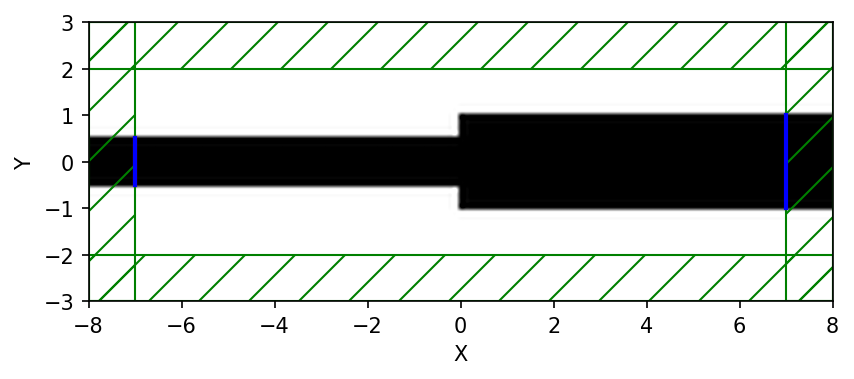

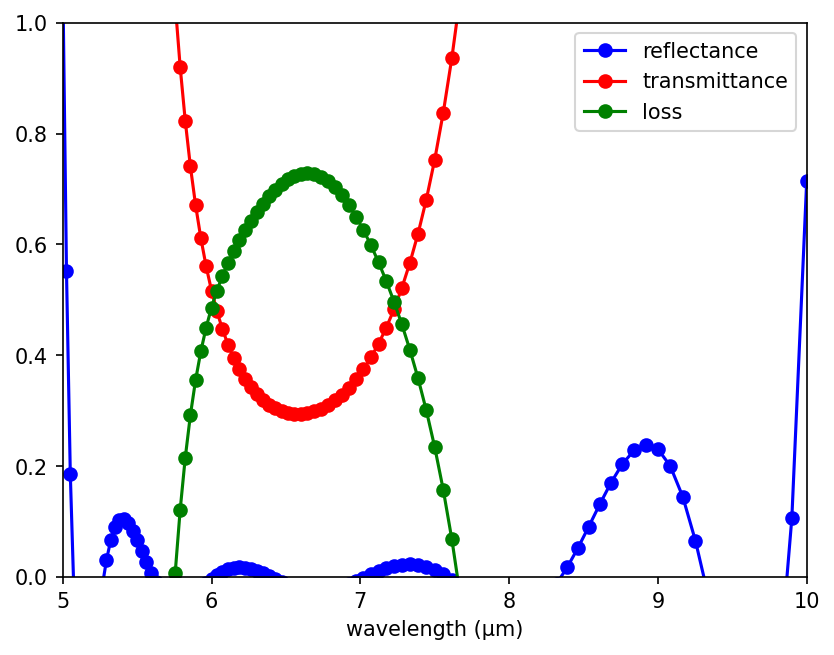

In [10]:
cell = mp.Vector3(16, 6, 0) 
geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-3, 0),
        material=mp.Medium(epsilon=12),
    ),
    
    mp.Block(        
        mp.Vector3(2, 13, mp.inf),        
        center=mp.Vector3(6.5, 0),        
        material=mp.Medium(epsilon=12),        
        e1=mp.Vector3(0, 1),        
        e2=mp.Vector3(1, 0),    
    ),
]

pml_layers = [mp.PML(1.0)] 
resolution = 10
sources = [
    mp.Source(
        mp.ContinuousSource(wavelength=2 * (11**0.5), width=20),
        component=mp.Ez,
        center=mp.Vector3(-7, 0), 
        size=mp.Vector3(0, 1),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)


filename2 = "media/smallToLarge.mp4"

if disable_video > 0:
    # Animate the plot
    f = plt.figure(dpi=150) # Animate the plot 
    Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
    sim.run(mp.at_every(0.5, Animate), until=200)
    plt.close()

    fps = 10
    Animate.to_mp4(fps, filename2)
    
# Transmittance and Reflectance
sim.reset_meep()

geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-3, 0),
        material=mp.Medium(epsilon=12),
    ),
    
    mp.Block(        
        mp.Vector3(2, 13, mp.inf),        
        center=mp.Vector3(6.5, 0),        
        material=mp.Medium(epsilon=12),        
        e1=mp.Vector3(0, 1),        
        e2=mp.Vector3(1, 0),    
    ),
]

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-7, 0), 
        size=mp.Vector3(0, 1),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-7, 0, 0), size=mp.Vector3(0, 1, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(7, 0, 0), size=mp.Vector3(0, 2, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)



pt = mp.Vector3(7, 5.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# for normalization run, save flux fields data for reflection plane
bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

if enable_output > 0:
    plt.figure(dpi=150)
    sim.plot2D()
    plt.show()
    wl = []
    Rs = []
    Ts = []
    for i in range(nfreq):
        wl = np.append(wl, 1 / flux_freqs[i])
        Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
        Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, Rs, "bo-", label="reflectance")
        plt.plot(wl, Ts, "ro-", label="transmittance")
        plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
        plt.axis([5.0, 10.0, 0, 1])
        plt.xlabel("wavelength (μm)")
        plt.legend(loc="upper right")
        plt.show()
Video(filename2)

## Large to Small

-----------
Initializing structure...
time for choose_chunkdivision = 9.01222e-05 s
Working in 2D dimensions.
Computational cell is 16 x 6 x 0 with resolution 10
     block, center = (3,0,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (-6.5,0,0)
          size (2,13,1e+20)
          axes (0,1,0), (1,0,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0107131 s
-----------
run 0 finished at t = 50.050000000000004 (1001 timesteps)
     block, center = (3,0,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (-6.5,0,0)
          size (2,13,1e+20)
          axes (0,1,0), (1,0,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


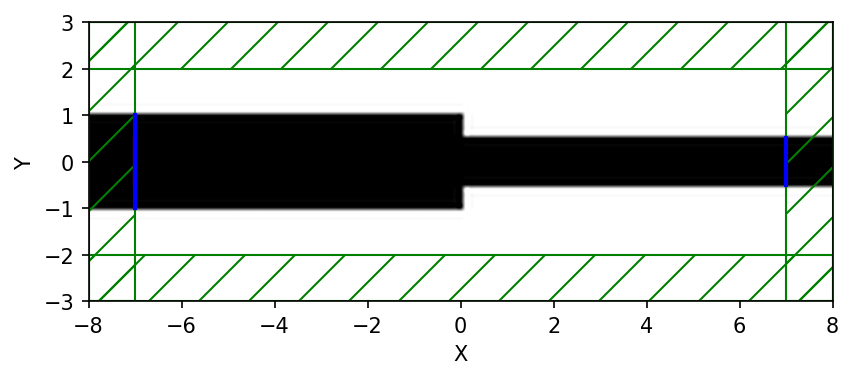

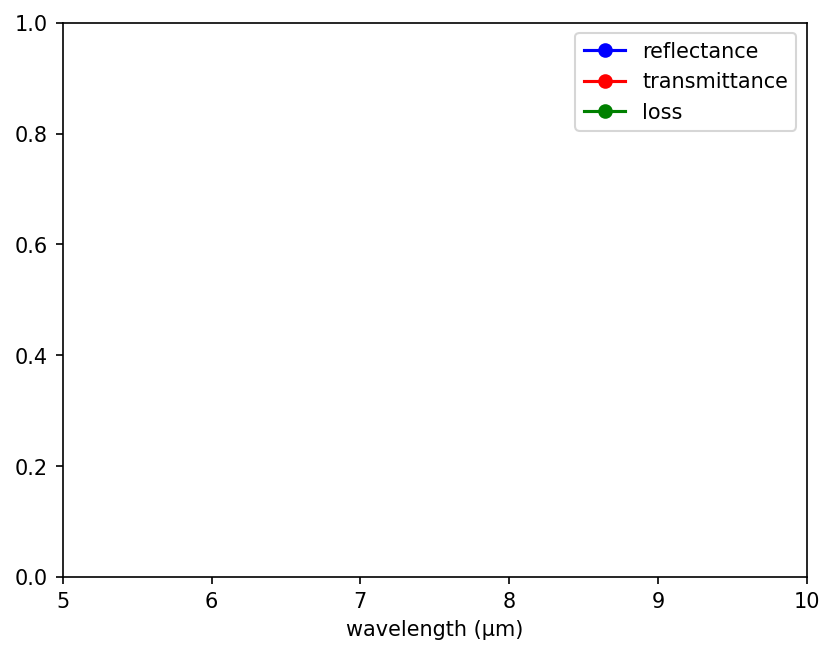

In [5]:

cell = mp.Vector3(16, 6, 0) 
geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(3, 0),
        material=mp.Medium(epsilon=12),
    ),
    
    mp.Block(        
        mp.Vector3(2, 13, mp.inf),        
        center=mp.Vector3(-6.5, 0),        
        material=mp.Medium(epsilon=12),        
        e1=mp.Vector3(0, 1),        
        e2=mp.Vector3(1, 0),    
    ),
]

pml_layers = [mp.PML(1.0)] 
resolution = 10
sources = [
    mp.Source(
        mp.ContinuousSource(wavelength=2 * (11**0.5), width=20),
        component=mp.Ez,
        center=mp.Vector3(-7, 0), 
        size=mp.Vector3(0, 1),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)


filename3 = "media/LargetoSmall.mp4"

if disable_video > 0:
    # Animate the plot
    f = plt.figure(dpi=150) # Animate the plot 
    Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
    sim.run(mp.at_every(0.5, Animate), until=200)
    plt.close()

    fps = 10
    Animate.to_mp4(fps, filename3)
    
# Transmittance and Reflectance
sim.reset_meep()

geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(3, 0),
        material=mp.Medium(epsilon=12),
    ),
    
    mp.Block(        
        mp.Vector3(2, 13, mp.inf),        
        center=mp.Vector3(-6.5, 0),        
        material=mp.Medium(epsilon=12),        
        e1=mp.Vector3(0, 1),        
        e2=mp.Vector3(1, 0),    
    ),
]

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-7, 0), 
        size=mp.Vector3(0, 1),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-7, 0, 0), size=mp.Vector3(0, 2, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(7, 0, 0), size=mp.Vector3(0, 1, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)


pt = mp.Vector3(7, 5.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# for normalization run, save flux fields data for reflection plane
bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

if enable_output > 0:
    plt.figure(dpi=150)
    sim.plot2D()
    plt.show()
    wl = []
    Rs = []
    Ts = []
    for i in range(nfreq):
        wl = np.append(wl, 1 / flux_freqs[i])
        Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
        Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, Rs, "bo-", label="reflectance")
        plt.plot(wl, Ts, "ro-", label="transmittance")
        plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
        plt.axis([5.0, 10.0, 0, 1])
        plt.xlabel("wavelength (μm)")
        plt.legend(loc="upper right")
        plt.show()
Video(filename3)

## L Shaped

-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 2D dimensions.
Computational cell is 16 x 24 x 0 with resolution 10
     block, center = (-2,-9,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (4,2.5,0)
          size (1,24,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0353861 s
-----------
field decay(t = 50.050000000000004): 7.459722000804482e-06 / 7.459722000804482e-06 = 1.0
field decay(t = 100.05000000000001): 1.4415862450676575e-05 / 1.4415862450676575e-05 = 1.0
field decay(t = 150.1): 5.475074117788486e-06 / 1.4415862450676575e-05 = 0.37979511364798896
field decay(t = 200.15): 1.5200125832185129e-07 / 1.4415862450676575e-05 = 0.010544028069213262
field decay(t = 250.20000000000002): 1.5389027380364994e-09 / 1.4415862450676575e-05 = 0.000106750653

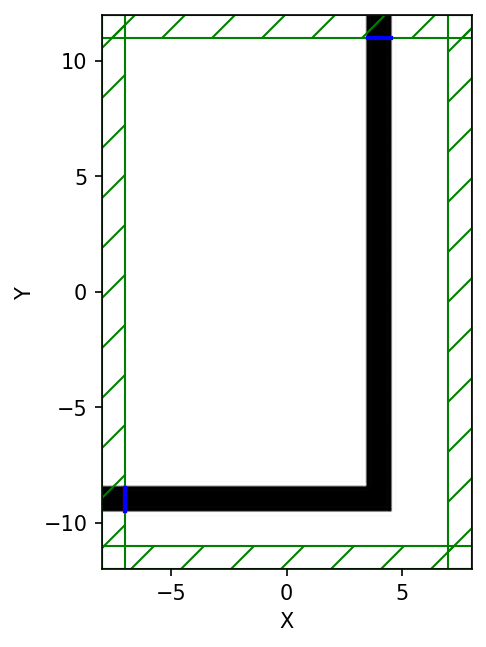

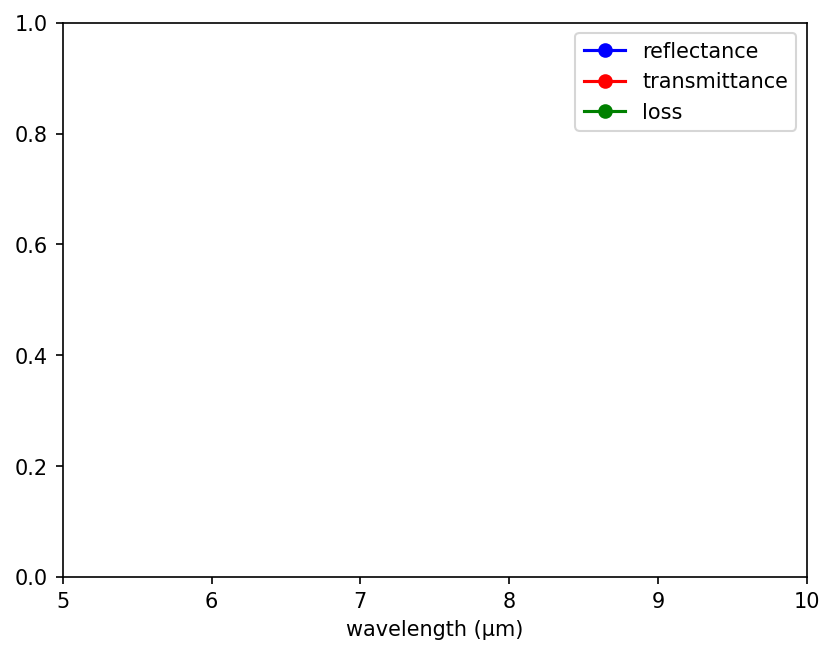

In [6]:

cell = mp.Vector3(16, 24, 0) 

geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-2, -9),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(1, 24, mp.inf),
        center=mp.Vector3(4, 2.5),
        material=mp.Medium(epsilon=12),
    ),

]

pml_layers = [mp.PML(1.0)] # Perfectly Macthed Layer, This absorbs radiated waves at the edges of the sim.
resolution = 10
sources = [
    mp.Source(
        mp.ContinuousSource(wavelength=2 * (11**0.5), width=20),
        component=mp.Ez,
        center=mp.Vector3(-7, -9), 
        size=mp.Vector3(0, 1),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)



filename4 = "media/L.mp4"

if disable_video > 0:
    # Animate the plot
    f = plt.figure(dpi=150) # Animate the plot 
    Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
    sim.run(mp.at_every(0.5, Animate), until=200)
    plt.close()

    fps = 10
    Animate.to_mp4(fps, filename4)
    Video(filename4)
    
    
# Transmittance and Reflectance
sim.reset_meep()

geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-2, -9),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(1, 24, mp.inf),
        center=mp.Vector3(4, 2.5),
        material=mp.Medium(epsilon=12),
    ),

]

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-7, -9), 
        size=mp.Vector3(0, 1),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-7, -9, 0), size=mp.Vector3(0, 1, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(4, 11, 0), size=mp.Vector3(1, 0, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)


pt = mp.Vector3(0, 8)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# for normalization run, save flux fields data for reflection plane
bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)
    
   
if enable_output > 0:
    plt.figure(dpi=150)
    sim.plot2D()
    plt.show()
    wl = []
    Rs = []
    Ts = []
    for i in range(nfreq):
        wl = np.append(wl, 1 / flux_freqs[i])
        Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
        Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, Rs, "bo-", label="reflectance")
        plt.plot(wl, Ts, "ro-", label="transmittance")
        plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
        plt.axis([5.0, 10.0, 0, 1])
        plt.xlabel("wavelength (μm)")
        plt.legend(loc="upper right")
        plt.show()
    
Video(filename4)
    

## C Shaped

-----------
Initializing structure...
time for choose_chunkdivision = 0.000102043 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     block, center = (-2.5,5.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (-2.5,-5.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,0,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.0259001 s
-----------
field decay(t = 50.050000000000004): 4.089631580540167e-06 / 4.089631580540167e-06 = 1.0
field decay(t = 100.05000000000001): 1.3412927209046968e-05 / 1.3412927209046968e-05 = 1.0
field decay(t = 150.1): 4.2959076052641425e-05 / 4.2959076052641425e-05 = 1.0
field decay(t = 200.15): 0.000434822076299069

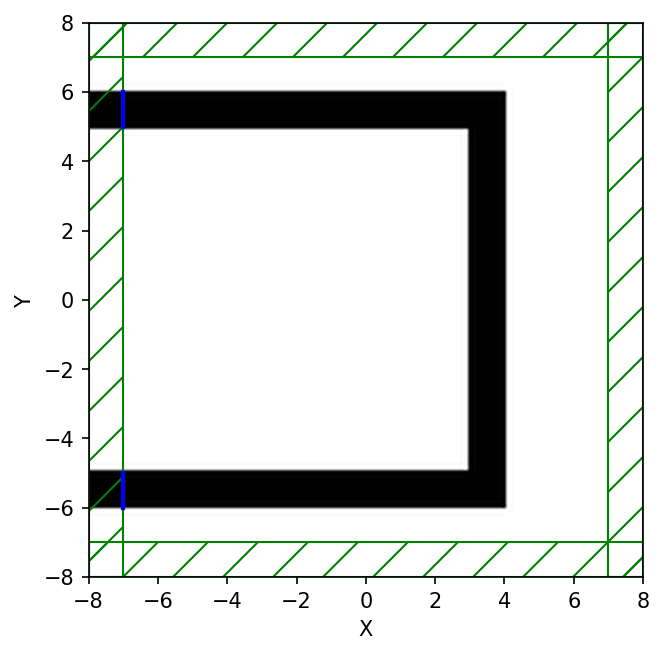

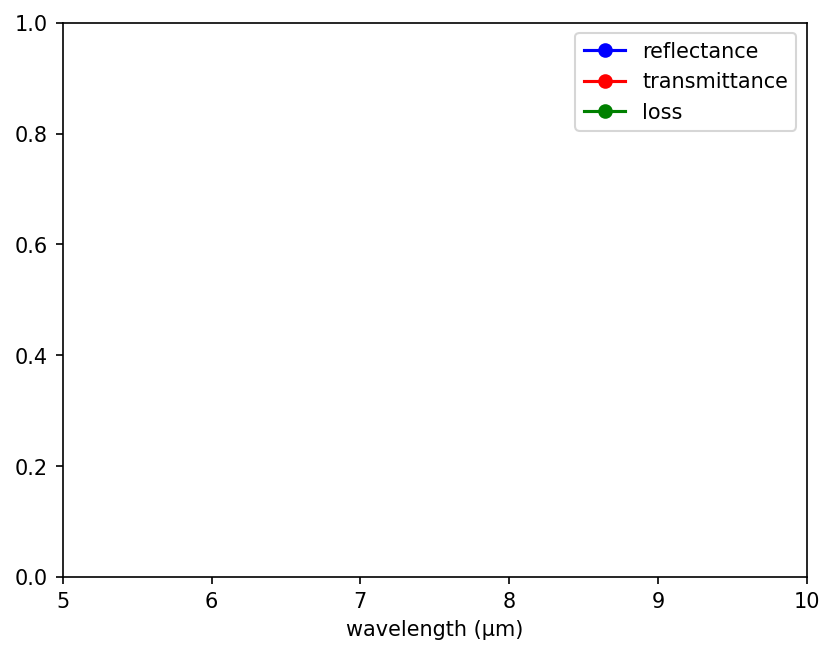

In [7]:

cell = mp.Vector3(16, 16, 0) 

geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-2.5, 5.5),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-2.5, -5.5),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(1, 12, mp.inf),
        center=mp.Vector3(3.5, 0),
        material=mp.Medium(epsilon=12),
    ),
]

pml_layers = [mp.PML(1.0)] # Perfectly Macthed Layer, This absorbs radiated waves at the edges of the sim.
resolution = 10
sources = [
    mp.Source(
        mp.ContinuousSource(wavelength=2 * (11**0.5), width=20),
        component=mp.Ez,
        center=mp.Vector3(-7, -5.5), 
        size=mp.Vector3(0, 1),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)


filename5 = "media/C.mp4"

if disable_video > 0:
    # Animate the plot
    f = plt.figure(dpi=150) # Animate the plot 
    Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
    sim.run(mp.at_every(0.5, Animate), until=200)
    plt.close()

    fps = 10
    Animate.to_mp4(fps, filename5)
    Video(filename5)
    
sim.reset_meep()

geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-2.5, 5.5),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-2.5, -5.5),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(1, 12, mp.inf),
        center=mp.Vector3(3.5, 0),
        material=mp.Medium(epsilon=12),
    ),
]

sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-7, -5.5), 
        size=mp.Vector3(0, 1),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-7, -5.5, 0), size=mp.Vector3(0, 1, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(-7, 5.5, 0), size=mp.Vector3(0, 1, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)



pt = mp.Vector3(-6, 5.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# for normalization run, save flux fields data for reflection plane
bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)


if enable_output > 0:
    plt.figure(dpi=150)
    sim.plot2D()
    plt.show()
    wl = []
    Rs = []
    Ts = []
    for i in range(nfreq):
        wl = np.append(wl, 1 / flux_freqs[i])
        Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
        Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

    if mp.am_master():
        plt.figure(dpi=150)
        plt.plot(wl, Rs, "bo-", label="reflectance")
        plt.plot(wl, Ts, "ro-", label="transmittance")
        plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
        plt.axis([5.0, 10.0, 0, 1])
        plt.xlabel("wavelength (μm)")
        plt.legend(loc="upper right")
        plt.show()
        
Video(filename5)

## Bucket

In [8]:

cell = mp.Vector3(16, 16, 0) 

geometry = [
    mp.Block(
        mp.Vector3(8, 12, mp.inf),
        center=mp.Vector3(0, -5),
        material=mp.Medium(epsilon=12),
    ),
]

pml_layers = [mp.PML(1.0)] # Perfectly Macthed Layer, This absorbs radiated waves at the edges of the sim.
resolution = 10
sources = [
    mp.Source(
        mp.ContinuousSource(wavelength=2 * (11**0.5), width=20),
        component=mp.Ez,
        center=mp.Vector3(0, -7), 
        size=mp.Vector3(4, 0),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

filename6 = "media/bucket.mp4"

# Animate the plot
if disable_video > 0:
    f = plt.figure(dpi=150) # Animate the plot 
    Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
    sim.run(mp.at_every(0.5, Animate), until=200)
    plt.close()

    fps = 10
    Animate.to_mp4(fps, filename6)
    
Video(filename6)
